# $\color{Green}{\text{Fundamentals of Inference and Learning}}$ 
Name: Roduit \
Surname : Vincent \
Sciper: 325140

Again, as said in Homework 1, only relevant steps of the calculation are written in this notebook. The full derivation can be found in the PDF file attached to the submission
## Homework 2
### Exercise 1 : Classifying digits with Scikit-learn

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

### 1) Import and prepare datas

In [78]:
#Load datas
from sklearn.datasets import load_digits
x,y = load_digits(return_X_y=True)

In [79]:
# Change the output to 0 if even and 1 if odd
y = [0 if i % 2 == 0 else 1 for i in y]

In [80]:
#split into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=1)

In [81]:
#Check proportion of 1 in train and test
prop1_train = np.sum(y_train)/len(y_train)
prop1_test = np.sum(y_test)/len(y_test)
print(f'The proportion of 1 in the train set is {prop1_train*100:.2f}%')
print(f'The proportion of 1 in the test set is {prop1_test*100:.2f}%')

The proportion of 1 in the train set is 50.28%
The proportion of 1 in the test set is 50.74%


### 2) Logistic Regression

In [82]:
def accuracy(y_pred, y_test):
    return np.sum(y_pred == y_test)/len(y_test)
def f1_score(y_pred, y_test):
    tp = np.sum((y_pred == 1) & (y_test == 1))
    fp = np.sum((y_pred == 1) & (y_test == 0))
    fn = np.sum((y_pred == 0) & (y_test == 1))
    return 2*tp/(2*tp + fp + fn)

### Cross validation to fix hyperparamters
1) Case with $\mathscr{l}_1$ penalty

In [83]:
def function_evaluation(model,model_name, parameters, x_train, y_train, n_splits=5,x_test=x_test, y_test=y_test, scoring='accuracy'):
        #Create pipeline
        pipe = make_pipeline(StandardScaler(), model)
        #Create cross validation
        cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=1)
        #Create grid search
        grid = GridSearchCV(pipe, param_grid=parameters, cv=cv, scoring=scoring, return_train_score=True)
        #Fit model
        grid.fit(x_train, y_train)
        if model_name == 'logistic':
                cvOptParam = 1 / grid.best_params_['logisticregression__C']
                tested_paramters = 1 / np.array(grid.cv_results_['param_logisticregression__C'].data)
                pipe.set_params(logisticregression__C=cvOptParam)
                acc_pred = grid.score(x_test, y_test)
        elif model_name == 'ridge':
                cvOptParam = 2 * grid.best_params_['ridgeclassifier__alpha']
                tested_paramters = 2 * np.array(grid.cv_results_['param_ridgeclassifier__alpha'].data)
                pipe.set_params(ridgeclassifier__alpha=cvOptParam)
                acc_pred = grid.score(x_test, y_test)
        elif model_name == 'svc':
                cvOptParam = 1 / grid.best_params_['linearsvc__C']
                tested_paramters = 1 / np.array(grid.cv_results_['param_linearsvc__C'].data)
                pipe.set_params(linearsvc__C=cvOptParam)
                acc_pred = grid.score(x_test, y_test)
        else:
                tested_paramters = np.array(grid.cv_results_['param_randomforestclassifier__n_estimators'].data)
                cvOptParam = grid.best_params_['randomforestclassifier__n_estimators']
                pipe.set_params(randomforestclassifier__n_estimators=cvOptParam)
                acc_pred = grid.score(x_test, y_test)
        
        trainAcc = grid.cv_results_['mean_train_score']
        testAcc = grid.cv_results_['mean_test_score']

        print(f'In this case, the optimal parameter is {cvOptParam:.2f} and the accuracy on test set is {acc_pred*100:.2f}%')    

        return tested_paramters, trainAcc, testAcc, cvOptParam, acc_pred
    

In [84]:
def display_result(tested_paramters, parameter_name, trainAcc, testAcc, cvOptParam, title):
    plt.figure(figsize=(10, 5))
    plt.plot(tested_paramters, trainAcc, 'o-', label='Train accuracy')
    plt.plot(tested_paramters, testAcc, 'o-', label='Test accuracy')
    plt.axvline(cvOptParam, color='r', linestyle='--', label='Optimal lambda')

    plt.title('Accuracy for different values of' + title)
    plt.xlabel(parameter_name)
    plt.ylabel('Accuracy')

    plt.semilogx()
    plt.xlim([tested_paramters[0], tested_paramters[-1]])
    plt.grid(visible=True)
    plt.tight_layout()
    plt.legend()
    plt.show()

In this case, the optimal parameter is 2.07 and the accuracy on test set is 92.78%


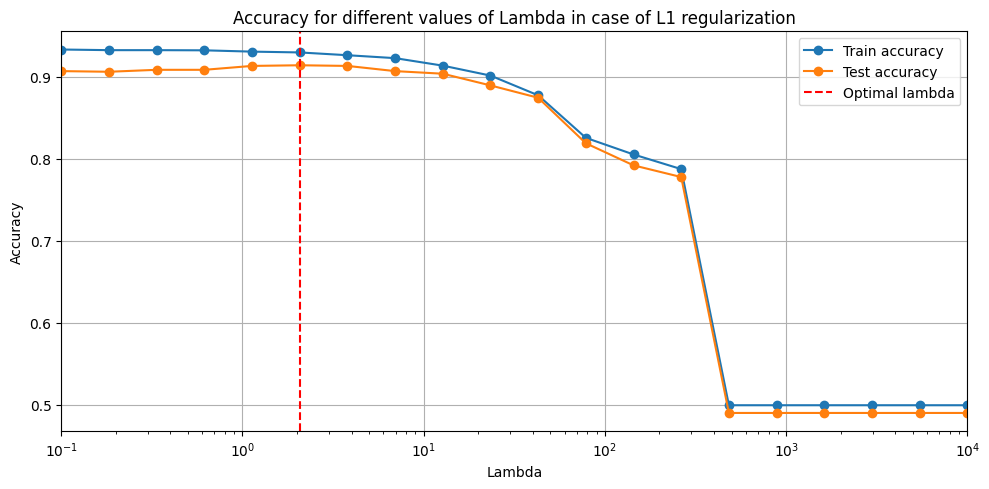

In [85]:
param_grid = [
    {'logisticregression__C': 1 / np.logspace(-1, 4, 20)}  #'C' is the inverse of lambda
]
logReg = LogisticRegression(penalty='l1', solver='liblinear')

tested_paramters_l1, trainAcc_l1, testAcc_l1, cvOptParam_l1, acc_l1 = function_evaluation(logReg,'logistic', param_grid, x_train, y_train)
display_result(tested_paramters_l1, 'Lambda', trainAcc_l1, testAcc_l1, cvOptParam_l1, ' Lambda in case of L1 regularization')

1) Case with $\mathscr{l}_2$ penalty

In this case, the optimal parameter is 6.95 and the accuracy on test set is 92.22%


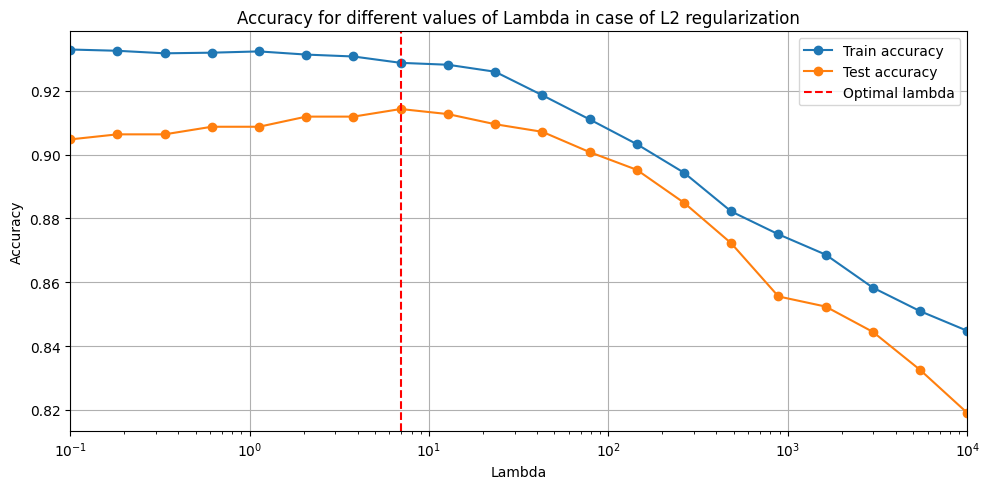

In [86]:
# perform a grid search to find the best parameter lambda

# Create a pipeline with logistic regression and scaling
logReg_l2 = LogisticRegression(penalty='l2', solver='liblinear')

# define the parameter grid
param_grid = [
    {'logisticregression__C': 1 / np.logspace(-1, 4, 20)}  #'C' is the inverse of lambda
]

tested_parameters_l2, trainAcc_l2, testAcc_l2, cvOptParam_l2, acc_l2 = function_evaluation(logReg_l2,'logistic', param_grid, x_train, y_train)
display_result(tested_parameters_l2, 'Lambda', trainAcc_l2, testAcc_l2, cvOptParam_l2, ' Lambda in case of L2 regularization')


Now let's find the prediction and the corresponding accuracy for the test set for the two logistic regressions:

In [87]:
print(f'For the L1 regularization, the accuracy on the test set is {acc_l1*100:.2f}%')
print(f'For the L2 regularization, the accuracy on the test set is {acc_l2*100:.2f}%')

For the L1 regularization, the accuracy on the test set is 92.78%
For the L2 regularization, the accuracy on the test set is 92.22%


3) Ridge and Hinge \
a) Ridge

In [88]:
from sklearn.linear_model import RidgeClassifier

In this case, the optimal parameter is 42.81 and the accuracy on test set is 90.93%


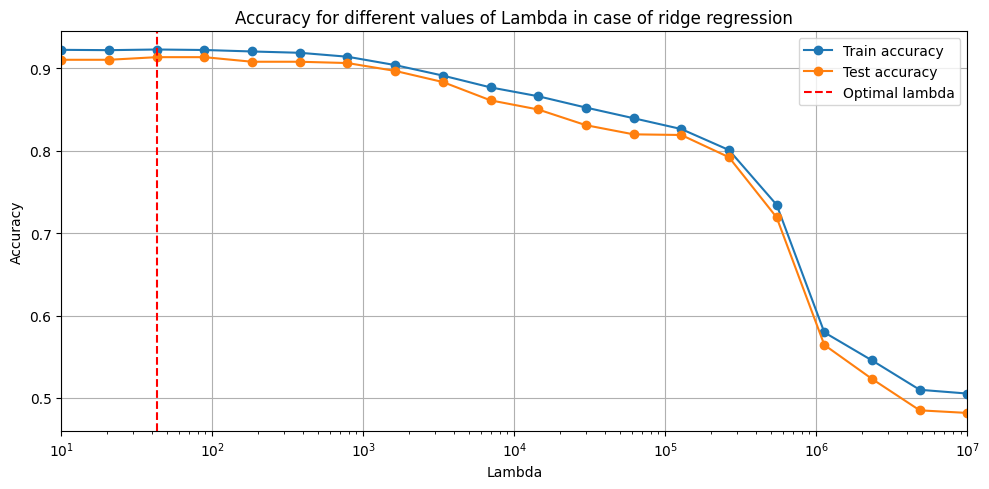

In [89]:
# Create a pipeline with Ridge regression and scaling
Ridge = RidgeClassifier()

# define the parameter grid
param_grid = [
    {'ridgeclassifier__alpha': np.logspace(1, 7, 20)/2} # alpha = 1/2C = lambda/2
]

tested_parameters_ridge, trainAcc_ridge, testAcc_ridge, cvOptParam_ridge, acc_ridge = function_evaluation(Ridge,'ridge', param_grid, x_train, y_train)
display_result(tested_parameters_ridge, 'Lambda', trainAcc_ridge, testAcc_ridge, cvOptParam_ridge, ' Lambda in case of ridge regression')

b) Hinge

In [90]:
from sklearn.svm import LinearSVC

In this case, the optimal parameter is 11.29 and the accuracy on test set is 92.59%


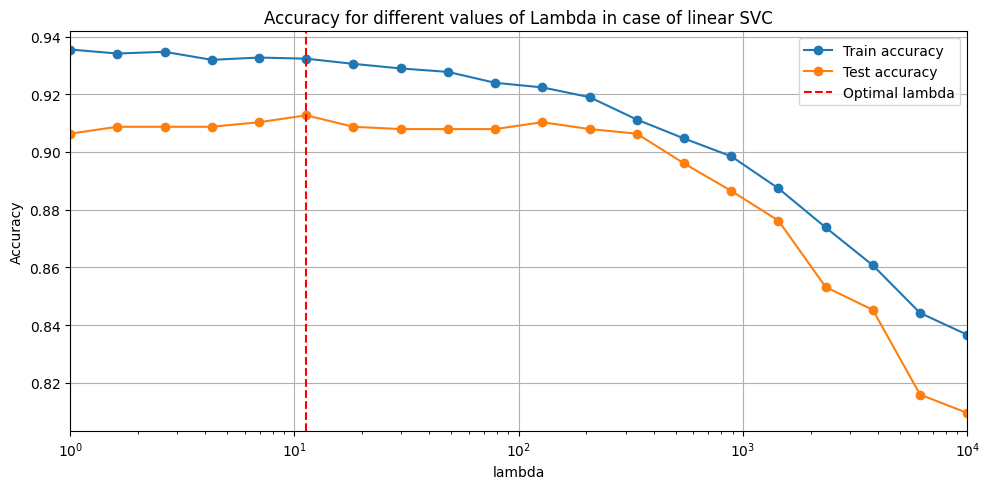

In [91]:
# Create a pipeline with LinearSVC and scaling
linear_svc = LinearSVC(loss='hinge', max_iter=100000)

param_grid = [
    {'linearsvc__C': 1 /np.logspace(0, 4, 20)}
]

tested_parameters_svc, trainAcc_svc, testAcc_svc, cvOptParam_svc, acc_svc = function_evaluation(linear_svc,'svc', param_grid, x_train, y_train)
display_result(tested_parameters_svc,'lambda', trainAcc_svc, testAcc_svc, cvOptParam_svc, ' Lambda in case of linear SVC')


In [92]:
print(f'For the Ridge case, the accuracy on the test set is {acc_ridge*100:.2f}%')
print(f'For the Hinge case, the accuracy on the test set is {acc_svc*100:.2f}%')

For the Ridge case, the accuracy on the test set is 90.93%
For the Hinge case, the accuracy on the test set is 92.59%


4. Random Forest

In this case, the optimal parameter is 4832.00 and the accuracy on test set is 96.11%


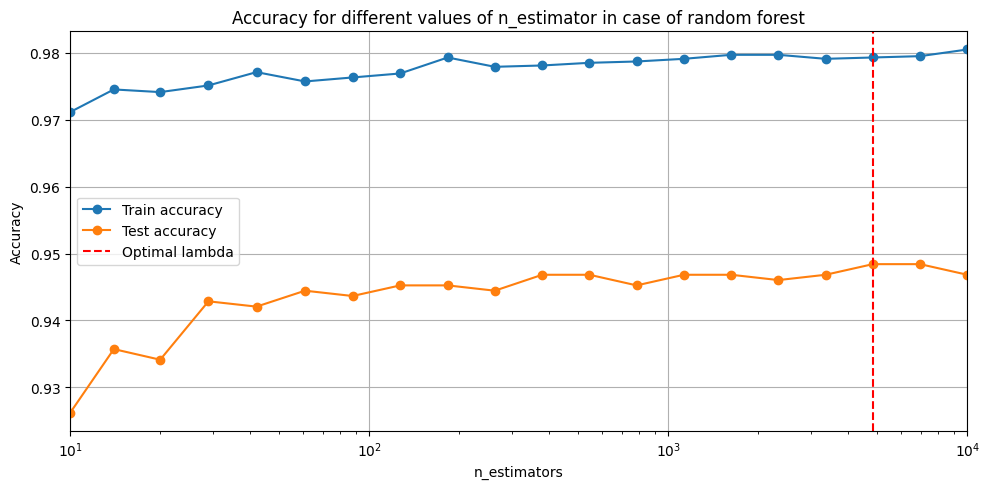

In [93]:
# Create a pipeline with LinearSVC and scaling
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(max_depth=5, random_state=1, min_samples_split=5)

# define the parameter grid
param_grid = [
    {'randomforestclassifier__n_estimators': np.logspace(1, 4, 20).astype(int)}
]

tested_parameters_forest, trainAcc_forest, testAcc_forest, cvOptParam_forest, acc_forest = function_evaluation(random_forest,'forest', param_grid, x_train, y_train)
display_result(tested_parameters_forest, 'n_estimators', trainAcc_forest, testAcc_forest, cvOptParam_forest, ' n_estimator in case of random forest')



5. Random Feature

In [94]:
# define the sigmoid function for numpy arrays
def sigmoid(x):
    x = np.array(x)
    return 1 / (1 + np.exp(-x))

In [95]:
#transform the data
def transform(X_train,X_test, D, d=x_train.shape[1]):
    F = np.random.normal(loc=0, scale= 1/np.sqrt(d), size=(D,d))
    U_train = 1 / np.sqrt(D) * sigmoid(F @ X_train.T).T
    U_test = 1 / np.sqrt(D) * sigmoid(F @ X_test.T).T
    return U_train, U_test

In this case, the optimal parameter is 2.81e-05 and the accuracy on test set is 92.96%


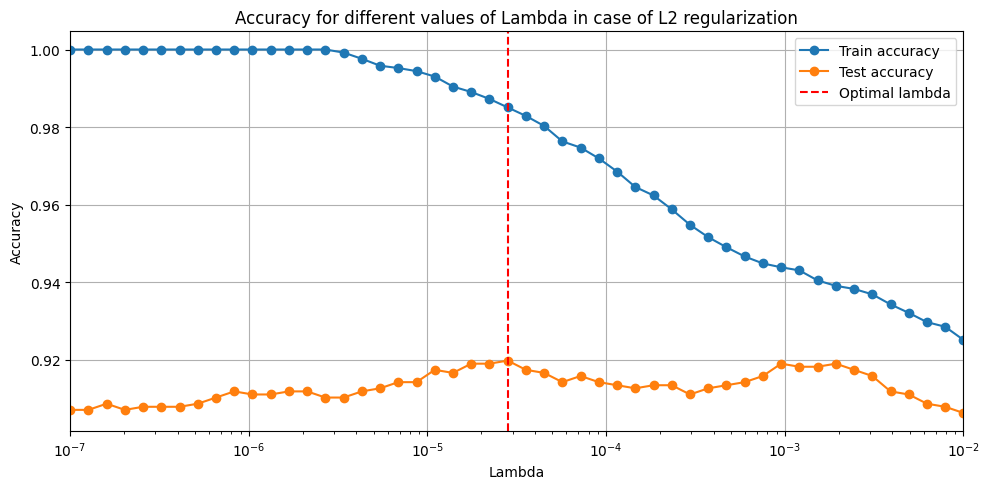

In this case, the optimal parameter is 1.10e-05 and the accuracy on test set is 95.56%


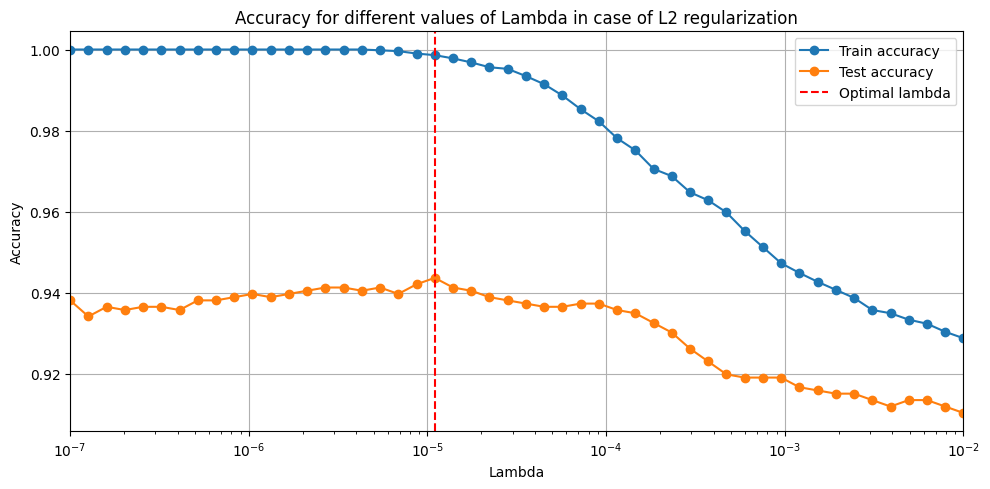

In this case, the optimal parameter is 6.55e-07 and the accuracy on test set is 94.81%


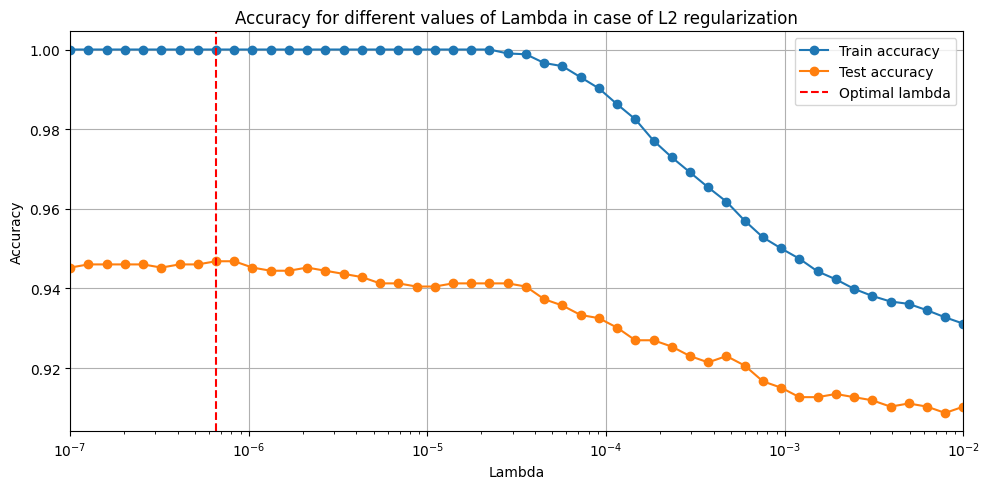

In [96]:
d = x_train.shape[1]
D_tab = np.array([3,6,12]) * d
param_grid = [
    {'C': 1 / np.logspace(-7, -2, 50)}  #'C' is the inverse of lambda
]
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
for D in D_tab:
    
    u_train, u_test = transform(x_train_scaled, x_test_scaled, D)
    
    logReg = LogisticRegression(penalty='l2', solver='liblinear')
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
    grid = GridSearchCV(logReg, param_grid=param_grid, cv=cv, scoring='accuracy', return_train_score=True)
    grid.fit(u_train, y_train)
    cvOptParam = 1 / grid.best_params_['C']
    tested_paramters = 1 / param_grid[0]['C']
    logReg = logReg.set_params(C=cvOptParam)
    acc_pred = grid.score(u_test, y_test)
    trainAcc = grid.cv_results_['mean_train_score']
    testAcc = grid.cv_results_['mean_test_score']
    print(f'In this case, the optimal parameter is {cvOptParam:.2e} and the accuracy on test set is {acc_pred*100:.2f}%')
    display_result(tested_paramters, 'Lambda', trainAcc, testAcc, cvOptParam, ' Lambda in case of L2 regularization')



The accuracy on the test set increases in the same way as D. But as D increases, the size of the feature increase and the time complexity becomes higher and higher. It's good noticing that as D becomes bigger, the test accuracy approaches 1. 

---
### Exercise 2 : Statistical Learning with Nearest-Neighbors

1. 

Lets rewrite the expression $\mathbb{E}_{X,Y}[(f(x)-Y)^2]$ as $\mathbb{E}_{X,Y}[(\hat{Y} - Y)^2]$, where $\hat{Y} = f(x)$ \
Now rewrite the expectation population risk using the law of total probability:
$$
\mathcal{R} = \mathbb{E}_{X,Y}[(\hat{Y} - Y)^2] = \mathbb{E}_{X}[\mathbb{E}_{Y|X}[(\hat{Y} - Y|X])^2]
$$
In order to find the maximum, one need to derive the Risk and set it equal to zero:
$$
\frac{\partial}{\partial{\hat{Y}}} \mathbb{E}_{X}[\mathbb{E}_{Y|X}[(\hat{Y} - Y|X])^2] = 2 \mathbb{E}_{Y|X}[\hat{Y} - Y|X] = 0
\Leftrightarrow \hat{Y} = \mathbb{E}_{Y|X}[Y|X] = f_{bayes}(x) \square
$$

2. 

The excess risk is 
$$
\Delta \mathcal{R} = \mathcal{R}_{ k-NN } - \mathcal{R}_{Bayes} = \mathbb{E} _{ \textbf{X} , Y , y _i , x _i } [(Y - f_{k-NN}(\textbf{X}))^2 - (Y-f_{Bayes}(\textbf{X}))^2]
$$
$$
= \mathbb{E}_{\textbf{X}}[\mathbb{E}_{Y|\textbf{X}, x_i,y_i}[(Y|\textbf{X})^2 + \frac{1}{k^2} \sum_{i,j \in \mathcal{N}_k(\textbf{X})}y_iy_j - \frac{2 * Y | \textbf{X}}{k}\sum_{i \in \mathcal{N}_k(\textbf{X})}y_i] - \mathbb{V}[Y|\textbf{X}]]
$$
$$
= \mathbb{E}_{\textbf{X}}[\mathbb{E}_{Y|\textbf{X}}[(Y|\textbf{X})^2] + \frac{1}{k^2}\sum_{i \neq j}\mathbb{E}_{y_i}[y_i]\mathbb{E}_{y_j}[y_j] + \frac{1}{k^2}\sum_{i = j}\mathbb{E}_{y_i}[y_i^2]- \frac{2 * \mathbb{E}[Y | \textbf{X}]}{k}\sum_{i \in \mathcal{N}_k(\textbf{X})}\mathbb{E}_{y_i}[y_i]- \mathbb{V}[Y|\textbf{X}]]
$$

But:
 * $y_i = Y|x_i $ then $\mathbb{E}[y_i] = f_{Bayes}(x_i)$
 * $\mathbb{E}[y_i^2] = \mathbb{V}[x_i]+f_{Bayes}(x_i)$
 * $\mathbb{E}[Y|\textbf{X}] = f_{Bayes}(\textbf{X}) $
  * $\mathbb{E}[(Y|\textbf{X})^2] =\mathbb{V}[\textbf{X}] * f_{Bayes}(\textbf{X})^2 $

Then:
$$
\Delta \mathcal{R} = \mathbb{E}_{\textbf{X}}[\frac{1}{k}\mathbb{V}[Y|\textbf{X}]+ f_{Bayes}(\textbf{X})^2 - \frac{1}{k^2} \sum_{i\neq j} f_{Bayes}(x_i)f_{Bayes}(x_j) +\frac{1}{k^2} \sum_{i = j} f_{Bayes}(x_i)^2 -\frac{2}{k}f_{Bayes}(\textbf{X}) \sum_{i \in \mathcal{N}(\textbf{X})}f_{Bayes}(x_i) ]
$$
$$
= \frac{\sigma^2}{k} + \mathbb{E}_{\textbf{X}}[(\frac{1}{k}\sum_{i \in \mathcal{N}_k(\textbf{X})}f_{Bayes}(x_i)-f_{Bayes}(\textbf{X}))^2] = b^2 + v
$$

3. 

We need to prove : $$ \Delta \mathcal{R} \leq L^2(\frac{k}{n})^{2/d} + \frac{\sigma^2}{k}$$

In order to prove this inequality, two assumptions have to be done:
1. The noise is homogeneous ( the risk can be written in the form found before)
2. The regression function is L-Lipschitz

First we nee to use the Cauchy-Schwarz inequality ($(\sum_{i=1}^n u_i v_i) \leq (\sum_{i=1}^n u_i^2)(\sum_{i=1}^n v_i^2)$):
$$
(\frac{1}{k}\sum_{i \in \mathcal{N}_k(\textbf{X})}f_{Bayes}(x_i)-f_{Bayes}(\textbf{X}))^2\leq k*\frac{1}{k^2} \sum_{i \in \mathcal{N}_k(\textbf{X})}(f_{Bayes}(x_i)-f_{Bayes}(\textbf{X}))^2
$$

Using now the fact that $f_{Bayes}$ is L-Lipschitz:
$$
\frac{1}{k} \sum_{i \in \mathcal{N}_k(\textbf{X})}(f_{Bayes}(x_i)-f_{Bayes}(\textbf{X}))^2
\leq \frac{L^2}{k} \sum_{i \in \mathcal{N}_k(\textbf{X})} || \textbf{$x_i$} - \textbf{X}||_2^2
$$

Using the expression found in 2:
$$
\Delta \mathcal{R} \leq \frac{\sigma^2}{k} +\frac{L^2}{k} \sum_{i \in \mathcal{N}_k(\textbf{X})} || \textbf{$x_i$} - \textbf{X}||_2^2
$$

The term $|| \textbf{x}_i - \textbf{X}||_2^2$ can be approximate with $l^2 = (\frac{k}{n})^{2/d}$, where n is the total number of points and d the number of feature. It can be seen with the following:
* The number of points in a certain volume should be k
* The volume of a cube is defined as $l^2$, where l is the length of the side of the cube
Then in order to have k points in the volume, we have the following equation:
$$
k = l^d * \frac{n}{V}
$$
where V is the total volume. If we set this volume to one, it remains:
$$
k = l^d * n \Leftrightarrow l = (\frac{k}{n})^{d^{-1}}
$$
Which finally leads to:
$$
|| \textbf{x}_i - \textbf{X}||_2^2 \approx l^2 =  (\frac{k}{n})^{2/d}
$$

Finally:
$$
\Delta \mathcal{R} \leq \frac{\sigma^2}{k} + L^2 (\frac{k}{n})^{2/d} \square
$$

This bound is composed of two terms, a bias term and a variance term. As k is involved in both terms, a trade-off betweem bias and variance has to be done. First, if we increase k, the variance would decrease. But at the same time, increasing k will also increase the bias. \
If we consider the extrem case where $k \rightarrow \infty$, the variance term goes to zero. It makes sense: as we consider all the neighbor, the prediction will be always the same. But at the same time, the bias will be high, as the prediction will not be accurate. \
Additionaly, the Risk increases with the square of L. The less the condition on $f_{Bayes}$ is, the worse the bound for the risk is. \
Finally, it can be seen that the bias decreases as the number of samples increases. It sounds logical as the more datas we have, the more precise the prediction is.

4. 

In [97]:
k = np.logspace(0,2,100)
L = 1
sigma = 1

In [98]:
def compute_bv_trade_off(n,d):

    bias = L**2 * (k / n) ** (2/d)
    variance = sigma**2 / k
    risk = bias + variance

    optimal_k = k[np.argmin(bias + variance)]
    min_risk = min(risk)

    #Plot the result
    plt.figure(figsize=(10, 5))

    plt.plot(k, bias, label='Bias')
    plt.plot(k, variance, label='Variance')
    plt.plot(k,risk, label='Risk')

    plt.title(f'Bias-variance tradeoff for n = {n} and d = {d}')
    plt.xlabel('k')
    plt.ylabel('Risk')
    plt.axvline(optimal_k, color='r', linestyle='--', label='Optimal k')
    plt.semilogx()
    plt.legend()
    plt.show()

    #print the best parameters
    print(f'The minimum risk is {min_risk:.2f} and is achieved for k = {optimal_k:.2f}')

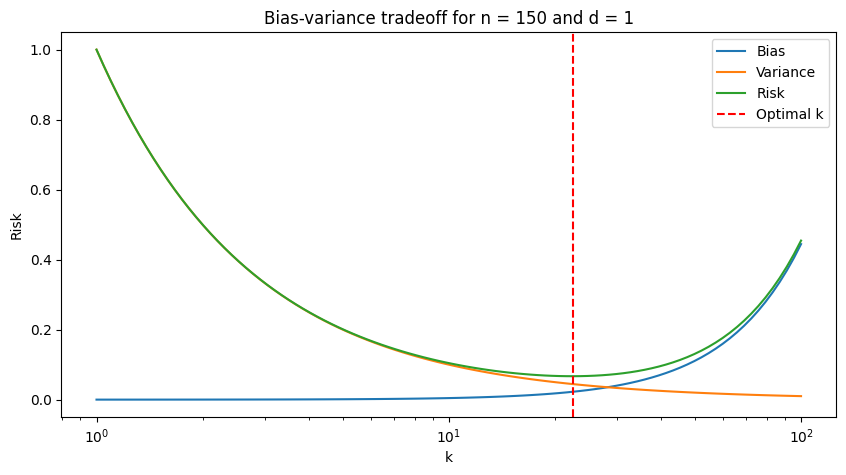

The minimum risk is 0.07 and is achieved for k = 22.57


In [99]:
compute_bv_trade_off(n=150,d=1)

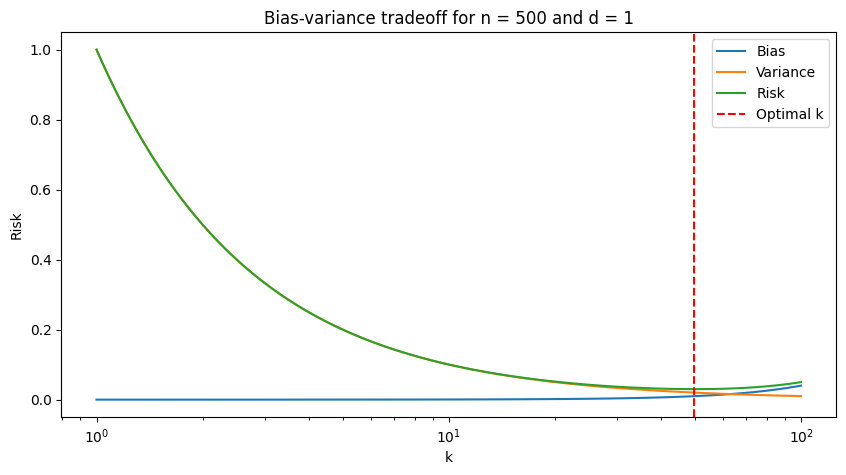

The minimum risk is 0.03 and is achieved for k = 49.77


In [100]:
compute_bv_trade_off(n=500, d=1)

By comparing these two plots, one can see that when n increases, the optimum k also increases. Since the slope of the bias curve is diminished, the the trade-off point can be moved to the right. It can also be seem that the risk is discreasing as expected.

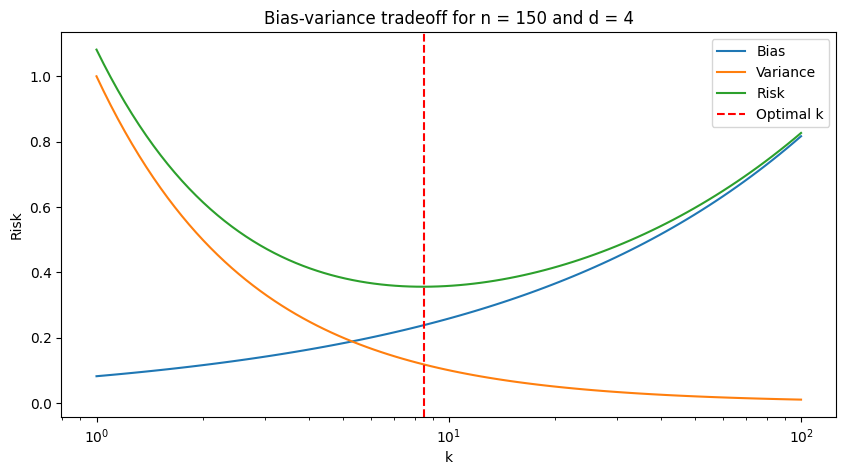

The minimum risk is 0.36 and is achieved for k = 8.50


In [101]:
compute_bv_trade_off(n=150, d=4)

### Interactive plot to see variations of both components

* Increasing d with all parameters the same increases the Risk
* Increasing n decreases the Risk

In [102]:
#Interaction to see both variation of n and d
from ipywidgets import IntSlider, interact
interact(compute_bv_trade_off, n=IntSlider(min=100, max=500), d=IntSlider(min=1, max=10))

interactive(children=(IntSlider(value=100, description='n', max=500, min=100), IntSlider(value=1, description=…

<function __main__.compute_bv_trade_off(n, d)>

5. 

In order to find the optimal k, we need to derivate the risk over k, set it equal to zero and solve for k:
$$
\frac{\partial}{\partial k} \Delta \mathcal{R} = -\frac{\sigma^2}{k^2} + \frac{L^2}{n^{2/d}} \cdot \frac{2}{d}k^{\frac{2-d}{d}} = 0
\Leftrightarrow \sigma^2 = \frac{2L^2}{dn^{\frac{2}{d}}}k^{\frac{2+d}{d}}
$$
Then:
$$
k_{opt} = (\frac{dn^{\frac{2}{d}}\sigma^2} {2L^2})^{\frac{d}{2+d}} \square
$$

$k_{opt}$ increases as n increases ($k\varpropto n^{\frac{2}{d}}$). As we have more datas, by taking more neighbors, it will in some sense eliminates the uncertainty by averaging more points. The variation of the optimal k as a function of d is shown in the plot below.

In [103]:
def k_opt(d, var, L, n):
    return ((d * n**(2/d) * var)/ (2 * L**2)) ** (d/(d+2))

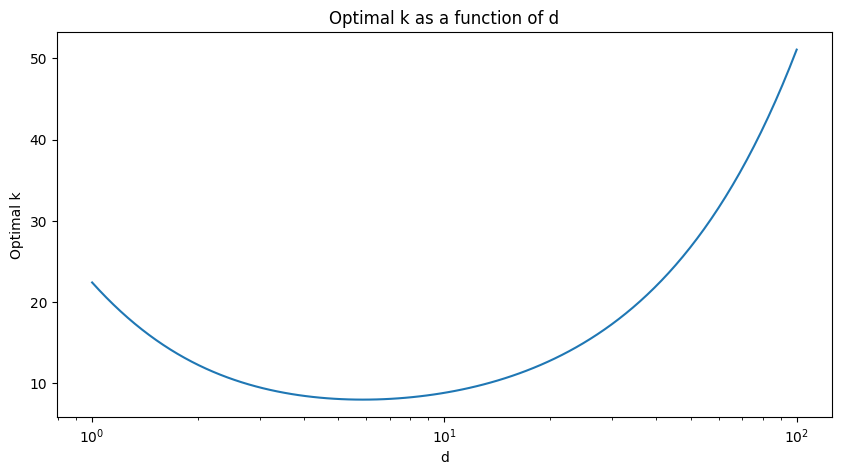

In [104]:
#Parameters
n = 150
L = 1
sigma = 1
d_tab = np.logspace(0,2,100)

#Compute the optimal k for each d
k_tab = k_opt(d_tab, sigma**2, L, n)

#Plot the result
plt.figure(figsize=(10, 5))
plt.plot(d_tab, k_tab)
plt.title('Optimal k as a function of d')
plt.xlabel('d')
plt.ylabel('Optimal k')
plt.semilogx()
plt.show()

6. 

For $\sigma = L = 1$ the value of the risk for the optimal k ($k_{opt}$) can be written as:
$$
\Delta \mathcal{R} \leq (\frac{2}{d\cdot n^{\frac{2}{d}}})^{\frac{d}{d+2}} + \frac{(\frac{d\cdot n^{\frac{2}{d}}}{2})^{\frac{2}{2+d}}}{n^{\frac{2}{d}}} 
= n^{-\frac{2}{2+d}} \{(\frac{d}{2})^{-\frac{d}{d+2}} + (\frac{d}{2})^{\frac{2}{2+d}}\} = (\frac{1}{n})^{\frac{2}{2+d}}\{(\frac{d}{2})^{-\frac{d}{d+2}} + (\frac{d}{2})^{\frac{2}{2+d}}\}
$$
$$
= (\frac{1}{n})^{\frac{2}{2+d}} \cdot \frac{d+2}{d} (\frac{d}{2})^{\frac{2}{d+2}}
$$

For a fixed d, if n increases, the excess risk decreases in $\frac{1}{n}$. Again, it seems logical: By increasing the number of datas, the precision will increase and then the prediction will be more accurate. 

7. 

Let's find an expression for n:
$$
\Delta \mathcal{R} = (\frac{1}{n})^{\frac{2}{2+d}} \cdot \frac{d+2}{2} (\frac{d}{2})^{\frac{2}{d+2}}
\Leftrightarrow n ^{\frac{2}{2+d}} =  \left(\frac{d}{2} \right)^{\frac{2}{2+d}} \left( \frac{d+2}{d} \right) \frac{1}{\Delta{R}}
$$
Finally 
$$
n_{opt} = \left(  \left(\frac{d}{2} \right)^{\frac{2}{2+d}} \left( \frac{d+2}{d} \right) \frac{1}{\Delta{R}} \right)^{\frac{2+d}{2}} =\left(\frac{d}{2} \right)  \left( \frac{d+2}{d \Delta{R} }\right)^{\frac{2+d}{2}}
$$

In [105]:
def n_opt(d, Risk):
    return (d/2) * ((d + 2)/(d * Risk))**((2+d)/2)

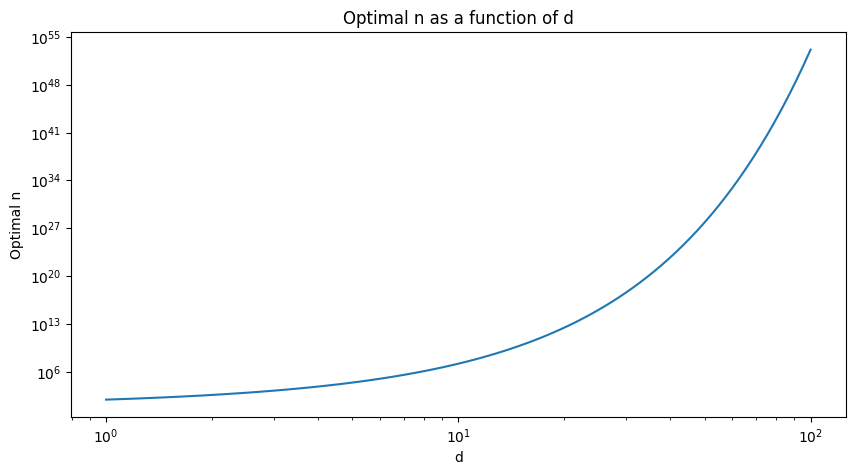

In [106]:
Risk = 0.1
d = np.logspace(0,2,100)
n_tab = n_opt(d, Risk)

#Plot the result
plt.figure(figsize=(10, 5))
plt.plot(d, n_tab)
plt.title('Optimal n as a function of d')
plt.xlabel('d')
plt.ylabel('Optimal n')
plt.loglog()
plt.show()



The issue that arises in this plot is that the number of optimal data points increases very quickly with the number of dimensions. For 100 features, the number of needed data points approaches $10^5$, which is unrealistic in practice. To address this problem, feature selection, dimension reduction, or other techniques have to be employed to avoid this issue.